# Representing Agents and Environments

**Reference**: *Artificial Intelligence: Foundations of Computational Agents, 2e*

An **environment** takes in actions of the agents, updates it internal state and returns the next percept, using the method do.

An **agent** takes the precept, updates its internal state, and output it next action.

An agent implements the method *select_action* that takes percept
and returns its next action.

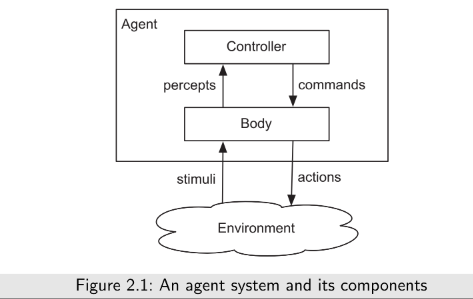

An **agent** is made up of a body and a **controller**.

The **controller** receives percepts from the body and sends commands to the body.

A **body** includes sensors that convert stimuli into percepts and actuators
that convert commands into actions.

Stimuli include light, sound, words typed on a keyboard, mouse movements, and physical bumps. The stimuli can also include information obtainedfrom a web page or from a database.

## Utility Functions

A simple way to trace the intermediate steps of algorithms.

In [1]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3

def visualize(func):
    """A decorator for algorithms that do interactive visualization.
    Ignored here.
    """
    return func

## Agents

In [2]:
class Agent(object):
    def __init__(self,env):
        """set up the agent"""
        self.env=env

    def go(self,n):
        """acts for n time steps"""
        raise NotImplementedError("go")   # abstract method

## Environment

In [3]:
class Environment(Displayable):
    def initial_percepts(self):
        """returns the initial percepts for the agent"""
        raise NotImplementedError("initial_percepts")   # abstract method

    def do(self,action):
        """does the action in the environment
        returns the next percept """
        raise NotImplementedError("do")   # abstract method

## Paper buying agent and environment

Consider a household trading agent that monitors the price of
some commodity (e.g., it checks online for special deals and for price increases for toilet paper) and how much the household has in stock. It must decide whether to buy more and how much to buy. The percepts are the price and the amount in stock. The command is the number of units the agent decides to buy (which is zero if the agent does not buy any). A percept trace specifies for each time point (e.g., each day) the price at that time and the amount in stock at that time. Percept traces are given in Figure 1.

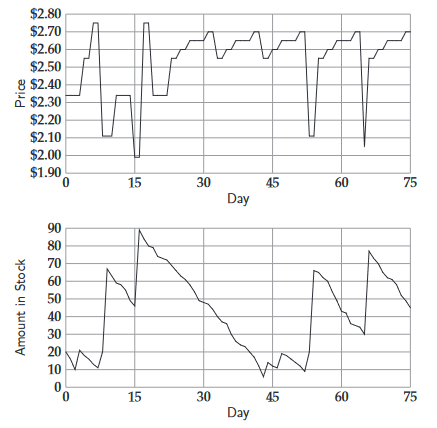

A command trace specifies how much the agent decides to buy at each time point. An example command trace is given in Figure 2.
The action of actually buying depends on the command but may be dif-
ferent. For example, the agent could issue a command to buy 12 rolls of toilet paper at a particular price. This does not mean that the agent actually buys 12 rolls because there could be communication problems, the store could have run out of toilet paper, or the price could change between deciding to buy and actually buying.


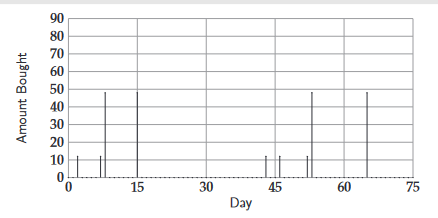

The environment state is given in terms of the time and the amount of paper in stock. It also remembers the in-stock history and the price history. The percept consistes of the price and the amount of paper in stock. The action of the agent is the number to buy.

Here we assume that the prices are obtained from the prices list (which cycles) plus a random integer in range [0, max price addon) plus a linear
linear ”inflation”. The agent cannot access the price model; it just observes the prices and the amount in stock

### Environment

In [4]:
import random

class TP_env(Environment):
    prices = [234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211,
    234, 234, 234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255,
    255, 260, 260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260,
    265, 265, 150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265,
    265, 265, 265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265,
    260, 265, 270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265,
    270, 270]
    max_price_addon = 20  # maximum of random value added to get price

    def __init__(self):
        """paper buying agent"""
        self.time=0
        self.stock=20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percepts(self):
        """return initial percepts"""
        self.stock_history.append(self.stock)
        price = self.prices[0] + random.randrange(self.max_price_addon)
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

    def do(self, action):
        """does action (buy) and returns percepts (price and instock)"""
        used = pick_from_dist({6:0.1, 5:0.1, 4:0.2, 3:0.3, 2:0.2, 1:0.1})
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        price = (self.prices[self.time%len(self.prices)] # repeating pattern
                 +random.randrange(self.max_price_addon) # plus randomness
                 +self.time//2)                          # plus inflation
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

In [5]:
def pick_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(str(item_prob_dist)+" is not a probability distribution")

### Agent

In [6]:
class TP_agent(Agent):
    def __init__(self, env):
        self.env = env
        self.spent = 0
        percepts = env.initial_percepts()
        self.ave = self.last_price = percepts['price']
        self.instock = percepts['instock']

    def go(self, n):
        """go for n time steps
        """
        for i in range(n):
            if self.last_price < 0.9*self.ave and self.instock < 60:
                tobuy = 48
            elif self.instock < 12:
                tobuy = 12
            else:
                tobuy = 0
            self.spent += tobuy*self.last_price
            percepts = env.do({'buy': tobuy})
            self.last_price = percepts['price']
            self.ave = self.ave+(self.last_price-self.ave)*0.05
            self.instock = percepts['instock']

In [7]:
env = TP_env()
ag = TP_agent(env)
ag.go(90)
ag.spent/env.time   ## average spent per time period

980.0

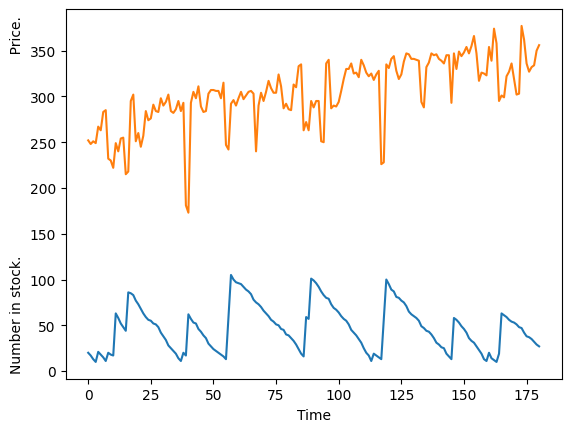

In [8]:
import matplotlib.pyplot as plt

class Plot_prices(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag,env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Number in stock.                                              Price.")

    def plot_run(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.plot(range(num),env.price_history,label="Price")
        #plt.legend(loc="upper left")
        plt.draw()

pl = Plot_prices(ag,env)
ag.go(90);
pl.plot_run()

## Exercise

Design a better controller for a paper-buying agent.

- Justify a performance measure that is a fair comparison. Note that minimizing the total amount of money spent may be unfair to agents who have built
up a stockpile, and favors agents that end up with no paper.

- Give a controller that can work for many different price histories. An agent can use other local state variables, but does not have access to the environment model.

- Is it worthwhile trying to infer the amount of paper that the home uses?


## Hierarchical Controller

Each layer sees the layers below it as a virtual body from which it gets
percepts and to which it sends commands. The lower-level layers are able to
run much faster, react to those aspects of the world that need to be reacted to
quickly, and deliver a simpler view of the world to the higher layers, hiding
inessential information.

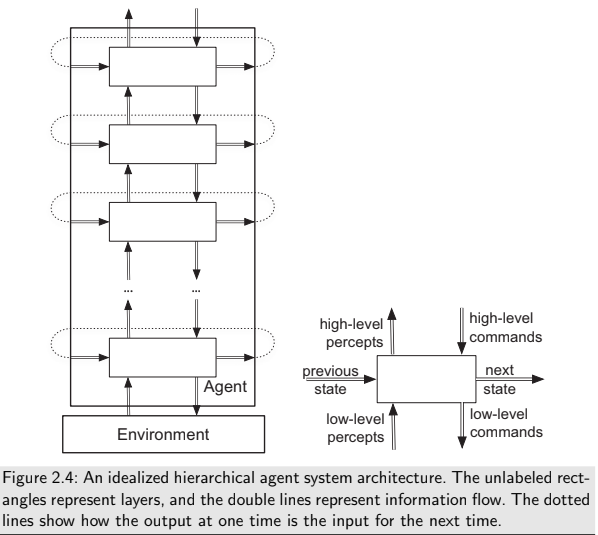

### An Autonomous Delivery Robot

Imagine a robot that has wheels and can pick up objects and put them down. It
has sensing capabilities so that it can recognize the objects that it must manipulate and can avoid obstacles. It can be given orders in natural language and obey them, making reasonable choices about what to do when its goals con-
flict. Such a robot could be used in an office environment to deliver packages,
mail, and/or coffee, or it could be embedded in a wheelchair to help disabled
people. It should be useful as well as safe.

the autonomous delivery robot has the following as inputs:

- prior knowledge, provided by the agent designer, about its own capabilities,
what objects it may encounter and have to differentiate, what requests mean,
and perhaps about its environment, such as a map;
- past experience obtained while acting, for instance, about the effect of its
actions, what objects are common in the world, and what requests to expect
at different times of the day;
- goals in terms of what it should deliver and when, as well as preferences that
specify trade-offs, such as when it must forgo one goal to pursue another, or
the trade-off between acting quickly and acting safely; and
- observations about its environment from such input devices as cameras,
sonar, touch, sound, laser range finders, or keyboards.

The robot’s outputs are motor controls that specify how its wheels should turn,
where its limbs should move, and what it should do with its grippers. Other
outputs may include speech and a video display.

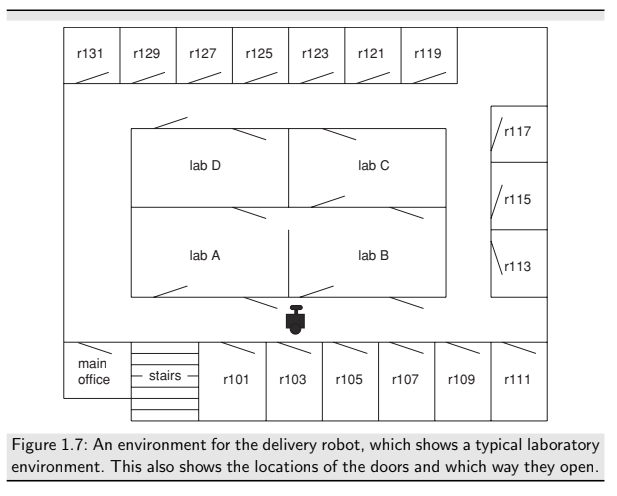

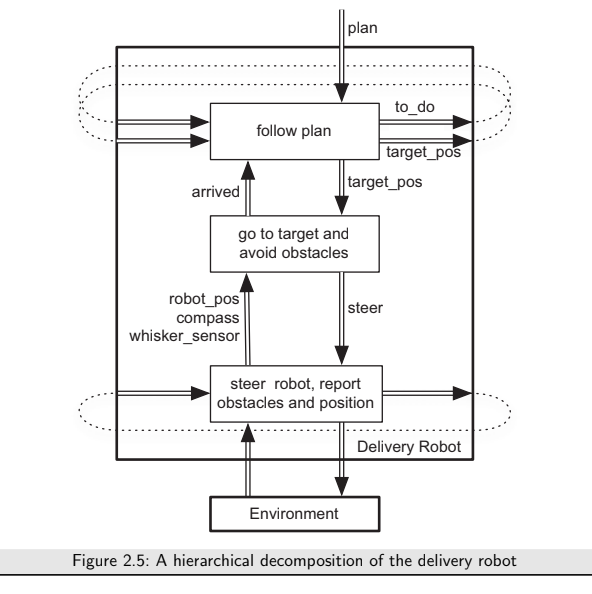

In [9]:
import math

class Rob_env(Environment):
    def __init__(self,walls = {}):
        """walls is a set of line segments
               where each line segment is of the form ((x0,y0),(x1,y1))
        """
        self.walls = walls

In [63]:
import time

class Rob_body(Environment):
    def __init__(self, env, init_pos=(0,0,90)):
        """ env is the current environment
        init_pos is a triple of (x-position, y-position, direction)
            direction is in degrees; 0 is to right, 90 is straight-up, etc
        """
        self.env = env
        self.rob_x, self.rob_y, self.rob_dir = init_pos
        self.turning_angle = 18   # degrees that a left makes
        self.whisker_length = 6   # length of the whisker
        self.whisker_angle = 30   # angle of whisker relative to robot
        self.crashed = False
        # The following control how it is plotted
        self.plotting = False      # whether the trace is being plotted
        self.sleep_time = 0.05     # time between actions (for real-time plotting)
        # The following are data structures maintained:
        self.history = [(self.rob_x, self.rob_y)] # history of (x,y) positions
        self.wall_history = []     # history of hitting the wall

    def percepts(self):
        return {'rob_x_pos':self.rob_x, 'rob_y_pos':self.rob_y,
                'rob_dir':self.rob_dir, 'whisker':self.whisker() , 'crashed':self.crashed}
    initial_percepts = percepts  # use percept function for initial percepts too

    def do(self,action):
        """ action is {'steer':direction}
        direction is 'left', 'right' or 'straight'
        """
        if self.crashed:
            return self.percepts()
        direction = action['steer']
        compass_deriv = {'left':1,'straight':0,'right':-1}[direction]*self.turning_angle
        self.rob_dir = (self.rob_dir + compass_deriv +360)%360  # make in range [0,360)
        rob_x_new = self.rob_x + math.cos(self.rob_dir*math.pi/180)
        rob_y_new = self.rob_y + math.sin(self.rob_dir*math.pi/180)
        path = ((self.rob_x,self.rob_y),(rob_x_new,rob_y_new))
        if any(line_segments_intersect(path,wall) for wall in self.env.walls):
            self.crashed = True
            if self.plotting:
                print("Position"+str([self.rob_x])+","+str([self.rob_y]))
                plt.plot([self.rob_x],[self.rob_y],"r*",markersize=20.0)
                plt.draw()
        self.rob_x, self.rob_y = rob_x_new, rob_y_new
        self.history.append((self.rob_x, self.rob_y))
        if self.plotting and not self.crashed:
            print("Position"+str([self.rob_x])+","+str([self.rob_y]))
            plt.plot([self.rob_x],[self.rob_y],"go")
            plt.draw()
            plt.pause(self.sleep_time)
        return self.percepts()

    def whisker(self):
        """returns true whenever the whisker sensor intersects with a wall
        """
        whisk_ang_world = (self.rob_dir-self.whisker_angle)*math.pi/180
            # angle in radians in world coordinates
        wx = self.rob_x + self.whisker_length * math.cos(whisk_ang_world)
        wy = self.rob_y + self.whisker_length * math.sin(whisk_ang_world)
        whisker_line = ((self.rob_x,self.rob_y),(wx,wy))
        hit = any(line_segments_intersect(whisker_line,wall)
                    for wall in self.env.walls)
        if hit:
            self.wall_history.append((self.rob_x, self.rob_y))
            if self.plotting:
                print("Whisker - Position"+str([self.rob_x])+","+str([self.rob_y]))
                plt.plot([self.rob_x],[self.rob_y],"ro")
                plt.draw()
        return hit

def line_segments_intersect(linea,lineb):
    """returns true if the line segments, linea and lineb intersect.
    A line segment is represented as a pair of points.
    A point is represented as a (x,y) pair.
    """
    ((x0a,y0a),(x1a,y1a)) = linea
    ((x0b,y0b),(x1b,y1b)) = lineb
    da, db = x1a-x0a, x1b-x0b
    ea, eb = y1a-y0a, y1b-y0b
    denom = db*ea-eb*da
    if denom==0:    # line segments are parallel
        return False
    cb = (da*(y0b-y0a)-ea*(x0b-x0a))/denom  # position along line b
    if cb<0 or cb>1:
        return False
    ca = (db*(y0b-y0a)-eb*(x0b-x0a))/denom # position along line a
    return 0<=ca<=1




In [64]:
# Test cases:
assert line_segments_intersect(((0,0),(1,1)),((1,0),(0,1)))
assert not line_segments_intersect(((0,0),(1,1)),((1,0),(0.6,0.4)))
assert line_segments_intersect(((0,0),(1,1)),((1,0),(0.4,0.6)))

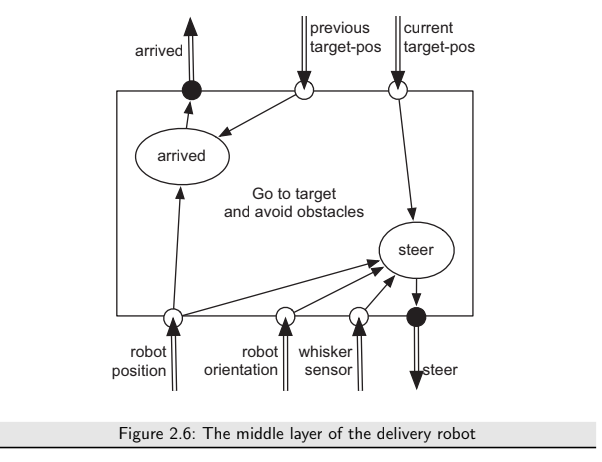

In [65]:
class Rob_middle_layer(Environment):
    def __init__(self,env):
        self.env=env
        self.percepts = env.initial_percepts()
        self.straight_angle = 11 # angle that is close enough to straight ahead
        self.close_threshold = 2  # distance that is close enough to arrived
        self.close_threshold_squared = self.close_threshold**2 # just compute it once

    def initial_percepts(self):
        return {}

    def do(self, action):
        """action is {'go_to':target_pos,'timeout':timeout}
        target_pos is (x,y) pair
        timeout is the number of steps to try
        returns {'arrived':True} when arrived is true
             or {'arrived':False} if it reached the timeout
        """
        if 'timeout' in action:
            remaining = action['timeout']
        else:
            remaining = -1    # will never reach 0
        target_pos = action['go_to']
        arrived = self.close_enough(target_pos)
        while not arrived and remaining != 0:
            self.percepts = self.env.do({"steer":self.steer(target_pos)})
            remaining -= 1
            arrived = self.close_enough(target_pos)
        return {'arrived':arrived}

    def steer(self,target_pos):
        if self.percepts['whisker']:
            self.display(3,'whisker on', self.percepts)
            return "left"
        else:
            gx,gy = target_pos
            rx,ry = self.percepts['rob_x_pos'],self.percepts['rob_y_pos']
            goal_dir = math.acos((gx-rx)/math.sqrt((gx-rx)*(gx-rx)
                                                   +(gy-ry)*(gy-ry)))*180/math.pi
            if ry>gy:
                goal_dir = -goal_dir
            goal_from_rob = (goal_dir - self.percepts['rob_dir']+540)%360-180
            assert -180 < goal_from_rob <= 180
            if goal_from_rob > self.straight_angle:
                return "left"
            elif goal_from_rob < -self.straight_angle:
                return "right"
            else:
                return "straight"

    def close_enough(self,target_pos):
        gx,gy = target_pos
        rx,ry = self.percepts['rob_x_pos'],self.percepts['rob_y_pos']
        return (gx-rx)**2 + (gy-ry)**2 <= self.close_threshold_squared


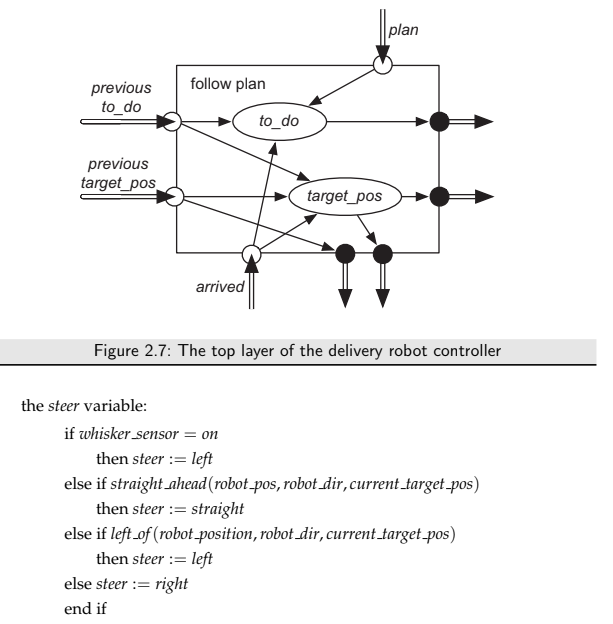

In [66]:
class Rob_top_layer(Environment):
    def __init__(self, middle, timeout=200, locations = {'mail':(-5,10),
                          'o103':(50,10), 'o109':(100,10),'storage':(101,51)} ):
        """middle is the middle layer
        timeout is the number of steps the middle layer goes before giving up
        locations is a loc:pos dictionary
            where loc is a named location, and pos is an (x,y) position.
        """
        self.middle = middle
        self.timeout = timeout  # number of steps before the middle layer should give up
        self.locations = locations

    def do(self,plan):
        """carry out actions.
        actions is of the form {'visit':list_of_locations}
        It visits the locations in turn.
        """
        to_do = plan['visit']
        for loc in to_do:
            position = self.locations[loc]
            arrived = self.middle.do({'go_to':position, 'timeout':self.timeout})
            #print("Arrived:"+loc +"Status:"+str(arrived))
            self.display(1,"Arrived at",loc,arrived)

In [67]:
import matplotlib.pyplot as plt

class Plot_env(object):
    def __init__(self, body,top):
        """sets up the plot
        """
        self.body = body
        plt.ion()
        plt.clf()
        plt.axes().set_aspect('equal')
        for wall in body.env.walls:
            ((x0,y0),(x1,y1)) = wall
            plt.plot([x0,x1],[y0,y1],"-k",linewidth=3)

        for loc in top.locations:
            (x,y) = top.locations[loc]
            plt.plot([x],[y],"k<")
            print(x+1.0,y+0.5,loc)
            plt.text(x+1.0,y+0.5,loc) # print the label above and to the right
        print()
        plt.plot([body.rob_x],[body.rob_y],"go")
        plt.draw()

    def plot_run(self):
        """plots the history after the agent has finished.
        This is typically only used if body.plotting==False
        """
        xs,ys = zip(*self.body.history)
        plt.plot(xs,ys,"go")
        wxs,wys = zip(*self.body.wall_history)
        plt.plot(wxs,wys,"ro")
        plt.draw()


The following code plots the agent as it acts in the world:

## Agents Modeling the World

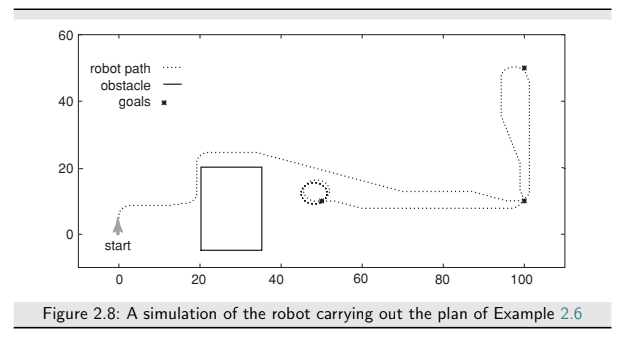

-4.0 10.5 mail
51.0 10.5 o103
101.0 10.5 o109
102.0 51.5 storage



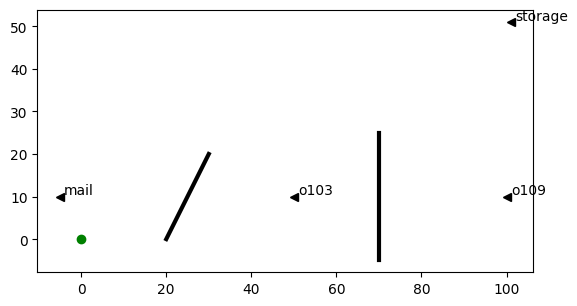

In [68]:
env = Rob_env({((20,0),(30,20)), ((70,-5),(70,25))})
body = Rob_body(env)
middle = Rob_middle_layer(body)
top = Rob_top_layer(middle)

# try:
pl=Plot_env(body,top)

# You can directly control the middle layer:
# middle.do({'go_to':(30,-10), 'timeout':200})
# Can you make it crash?

In [69]:
top.do({'visit':['o109','storage','o109','o103']})

Arrived at o109 {'arrived': True}
Arrived at storage {'arrived': True}
Arrived at o109 {'arrived': True}
Arrived at o103 {'arrived': True}


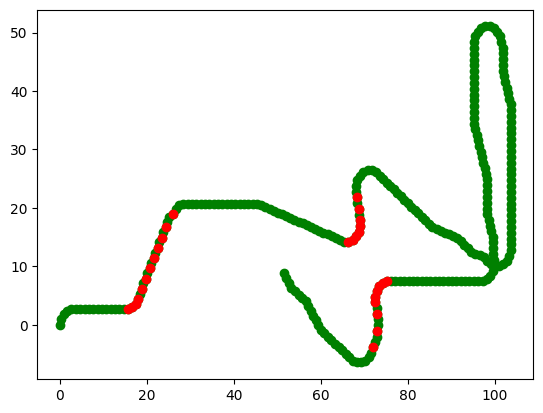

In [70]:
pl.plot_run()

The following code implements a robot trap. Write a controller that
can escape the “trap” and get to the goal.

72.0 0.5 goal



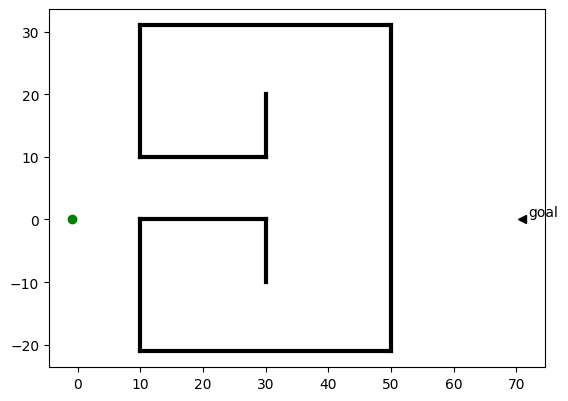

In [71]:
# Robot Trap for which the current controller cannot escape:
trap_env = Rob_env({((10,-21),(10,0)), ((10,10),(10,31)), ((30,-10),(30,0)),
                    ((30,10),(30,20)),  ((50,-21),(50,31)), ((10,-21),(50,-21)),
                    ((10,0),(30,0)),  ((10,10),(30,10)),  ((10,31),(50,31))})
trap_body = Rob_body(trap_env,init_pos=(-1,0,90))
trap_middle = Rob_middle_layer(trap_body)
trap_top = Rob_top_layer(trap_middle,locations={'goal':(71,0)})

# Robot trap exercise:
pl=Plot_env(trap_body,trap_top)


In [72]:
trap_top.do({'visit':['goal']})

Arrived at goal {'arrived': False}


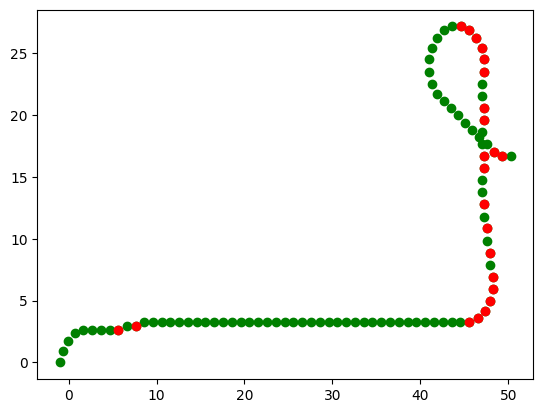

In [73]:
pl.plot_run()